In [1]:
import random
import os
import sys
import time
import numpy as np
import math
import zlib
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [2]:
from CurveCGen import *
from CurveEA import *

In [3]:
import subprocess
BLENDER_PATH="C:\\Program Files\\Blender Foundation\\Blender 3.3\\blender.exe"

In [4]:
OUTPUT_PATH="E:\\Research\\Statue Generator\\Generations"

In [5]:
def shannon_entropy(file_path):
    with open(file_path, "rb") as f:
        bytes = f.read()
    prob = [float(bytes.count(b)) / len(bytes) for b in set(bytes)]
    entropy = -sum([p * math.log(p) / math.log(2.0) for p in prob])
    return round(entropy,6)

In [7]:
def golden_ratio(vertices, edges):
    def euclidean_distance(v1, v2):
        return ((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2 + (v2[2] - v1[2])**2)**0.5
        
    golden_ratio = 1.61803398874989484820
    ratio_sum = 0
    ratio_count = 0
    
    for edge in edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        length = euclidean_distance(v1, v2)
        ratio = length / golden_ratio
        if ratio >= 1:
            ratio = 1 / ratio
        ratio_sum += ratio
        ratio_count += 1
    
    return ratio_sum / ratio_count


In [8]:
def perimeter(vertices, edges):
    perimeter = 0
    for edge in edges:
        vertex1, vertex2 = edge
        x1, y1, z1 = vertices[vertex1]
        x2, y2, z2 = vertices[vertex2]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        perimeter += distance
    return perimeter

In [9]:
def volume(vertices):
    vertices=np.array(vertices)
#     tri = Delaunay(vertices)
#     #print(tri.simplices)
#     tetra = vertices[tri.simplices]
#     volumes = np.zeros(len(tetra))

#     for i, t in enumerate(tetra):
#         a, b, c, d = t
#         v = (1.0/6.0) * np.abs(np.dot(b - a, np.cross(c - a, d - a)))
#         volumes[i] = v

#     total_volume = np.sum(volumes)
    
    ch=ConvexHull(vertices)
    total_volume=ch.volume
    
    return total_volume

In [10]:
def compression_ratio(filepath):
    with open(filepath, mode="rb") as fin, open(filepath[:-6]+"_compressed", mode="wb") as fout:
            data = fin.read()
            compressed_data = zlib.compress(data, zlib.Z_BEST_COMPRESSION)
            orig=sys.getsizeof(data)
            comp=sys.getsizeof(compressed_data)
            ratio=comp/orig
    
            return ratio

In [11]:
def gen_blender(ARR,GEN_NUM):
    
    os.mkdir(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))
    
    for i,C in enumerate(ARR):
        
        #[r,g,b,a,bd,me,ro,ss,[VERTICES,EDGES],[new_L,new_B,new_H]]

        VERTS=C[8][0]
        EDGES=C[8][1]
        MATERIAL=str([C[0],C[1],C[2],C[3]])
        BD=str(C[4])
        ME=str(C[5])
        RO=str(C[6])
        SS=str(C[7])
        FILE_NUM=str(i)
        
        with open(f'{OUTPUT_PATH}\\GEN_{GEN_NUM}\\VERTS_G{GEN_NUM}_S{i}.txt', 'w') as f:
            f.writelines(str(VERTS))

        #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G{GEN_NUM}_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))],capture_output=True,shell=True)
        #time.sleep(60)
        
        #print(f'Statue {i} Saved!')

## Basic Parameters for generation

In [17]:
L,B,H=10,12,17
POPULATION_SIZE=100

In [18]:
PARAMS=[]

## Initial Population

In [19]:
%%time

INITIAL_POPULATION=[]

for i in range(POPULATION_SIZE):
    CH=generate_chromosome(L,B,H)
    INITIAL_POPULATION.append(CH)
    get_stats(CH)
    print(f"Params of Statue - {i} has been saved!")
    print('-'*125)

PARAMS.append(INITIAL_POPULATION)

4
(R, G, B, A) = (0.220051, 0.002546, 0.326226, 0.448698)
Number of vertices = 23768
Number of edges = 23767
Bevel Depth = 2.43
Metallic = 0.298554
Roughness = 0.327729
Subsurface Level = 0
New Bounding Box - (L,B,H) = (5.23827,10.07312,8.346936)
Params of Statue - 0 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
2
(R, G, B, A) = (0.913986, 0.970375, 0.797745, 0.728714)
Number of vertices = 17414
Number of edges = 17413
Bevel Depth = 3.1
Metallic = 0.711335
Roughness = 0.484237
Subsurface Level = 2
New Bounding Box - (L,B,H) = (8.154833,2.21073,14.783491)
Params of Statue - 1 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
10


KeyboardInterrupt: 

In [82]:
%%time

os.mkdir(OUTPUT_PATH+"\\GEN_0")

for i,C in enumerate(PARAMS[0]):

    VERTS=C[8][0]
    EDGES=C[8][1]
    MATERIAL=str([C[0],C[1],C[2],C[3]])
    BD=str(C[4])
    ME=str(C[5])
    RO=str(C[6])
    SS=str(C[7])
    FILE_NUM=str(i)
    
    with open(f'{OUTPUT_PATH}\\GEN_0\\VERTS_G{0}_S{i}.txt', 'w') as f:
        f.writelines(str(VERTS))

    
    #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G0_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True)

    #time.sleep(60)
    
    print(f'Statue {i} Saved!')
    

Statue 0 Saved!
Statue 1 Saved!
Statue 2 Saved!
Statue 3 Saved!
Statue 4 Saved!
Statue 5 Saved!
Statue 6 Saved!
Statue 7 Saved!
Statue 8 Saved!
Statue 9 Saved!
Statue 10 Saved!
Statue 11 Saved!
Statue 12 Saved!
Statue 13 Saved!
Statue 14 Saved!
Statue 15 Saved!
Statue 16 Saved!
Statue 17 Saved!
Statue 18 Saved!
Statue 19 Saved!
Statue 20 Saved!
Statue 21 Saved!
Statue 22 Saved!
Statue 23 Saved!
Statue 24 Saved!
Statue 25 Saved!
Statue 26 Saved!
Statue 27 Saved!
Statue 28 Saved!
Statue 29 Saved!
Statue 30 Saved!
Statue 31 Saved!
Statue 32 Saved!
Statue 33 Saved!
Statue 34 Saved!
Statue 35 Saved!
Statue 36 Saved!
Statue 37 Saved!
Statue 38 Saved!
Statue 39 Saved!
Statue 40 Saved!
Statue 41 Saved!
Statue 42 Saved!
Statue 43 Saved!
Statue 44 Saved!
Statue 45 Saved!
Statue 46 Saved!
Statue 47 Saved!
Statue 48 Saved!
Statue 49 Saved!
Statue 50 Saved!
Statue 51 Saved!
Statue 52 Saved!
Statue 53 Saved!
Statue 54 Saved!
Statue 55 Saved!
Statue 56 Saved!
Statue 57 Saved!
Statue 58 Saved!
Statue 

## Crossover and Mutation for more generations

In [83]:
GENERATIONS=10

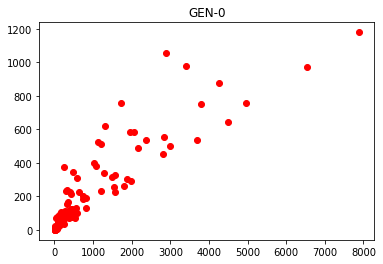

Statue-49 has the best fitness value in 0 generation.
Generation 1 generated successfully!
------------------------------------------------------------------------------------------------------------------------


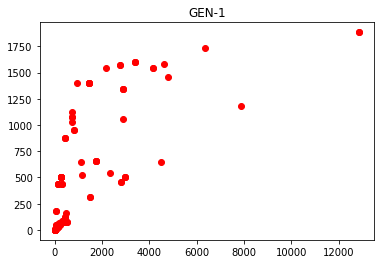

Statue-71 has the best fitness value in 1 generation.
Generation 2 generated successfully!
------------------------------------------------------------------------------------------------------------------------


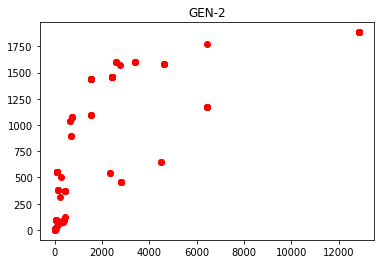

Statue-12 has the best fitness value in 2 generation.
Generation 3 generated successfully!
------------------------------------------------------------------------------------------------------------------------


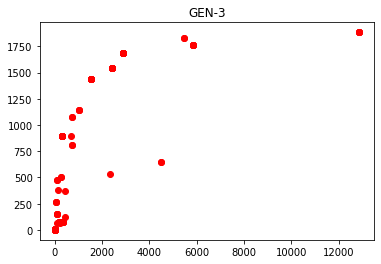

Statue-5 has the best fitness value in 3 generation.
Generation 4 generated successfully!
------------------------------------------------------------------------------------------------------------------------


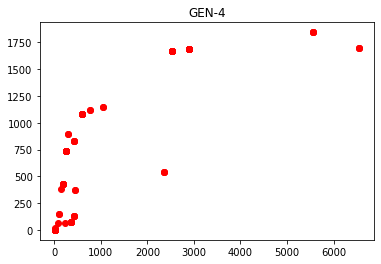

Statue-3 has the best fitness value in 4 generation.
Generation 5 generated successfully!
------------------------------------------------------------------------------------------------------------------------


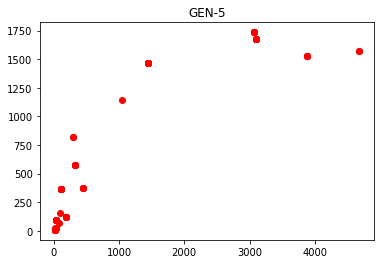

Statue-19 has the best fitness value in 5 generation.
Generation 6 generated successfully!
------------------------------------------------------------------------------------------------------------------------


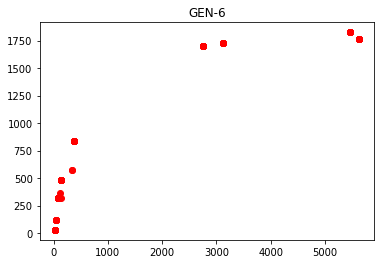

Statue-21 has the best fitness value in 6 generation.
Generation 7 generated successfully!
------------------------------------------------------------------------------------------------------------------------


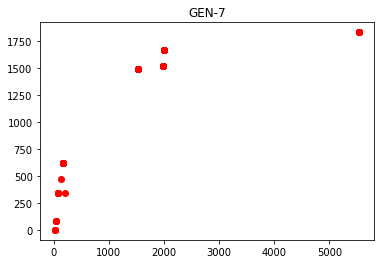

Statue-50 has the best fitness value in 7 generation.
Generation 8 generated successfully!
------------------------------------------------------------------------------------------------------------------------


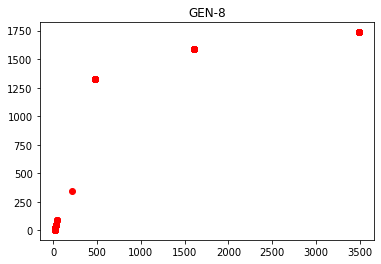

Statue-0 has the best fitness value in 8 generation.
Generation 9 generated successfully!
------------------------------------------------------------------------------------------------------------------------


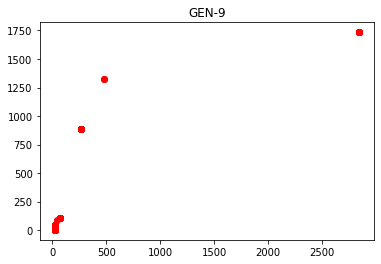

Statue-2 has the best fitness value in 9 generation.
Generation 10 generated successfully!
------------------------------------------------------------------------------------------------------------------------
Wall time: 9.25 s


In [84]:
%%time

ALL_FITNESS=[]
BEST_FITNESS=[]
MUTATION_CHOICES=[]
GEN_NUM=1

for _ in range(GENERATIONS):
    
    PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GEN_NUM-1)
    FITNESS=[]
    
    VOLUMES,PERIMETERS=[],[]
    
    for i in range(POPULATION_SIZE):
        
        VERTS=PARAMS[GEN_NUM-1][i][8][0]
        EDGES=PARAMS[GEN_NUM-1][i][8][1]
        
#         entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#         entropy=entropy/8 
        
#         cr=compression_ratio(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
        
#         gr=golden_ratio(VERTS,EDGES)
        
        v=volume(VERTS)
        p=perimeter(VERTS,EDGES)
        
        VOLUMES.append(1/v)
        PERIMETERS.append(p)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
        fitness=p/v
        FITNESS.append(round(fitness,6))
    
    
    plt.figure()
    plt.plot(PERIMETERS,VOLUMES,'ro')
    plt.title(f"GEN-{GEN_NUM-1}")
    plt.show()
    
    ALL_FITNESS.append(FITNESS)
    
    BEST_FITNESS.append(FITNESS.index(max(FITNESS)))
    print(f'Statue-{FITNESS.index(max(FITNESS))} has the best fitness value in {GEN_NUM-1} generation.')
    
    MODELS=[]
    
    GEN_MUTATION=[]
    
    for _ in range(int(POPULATION_SIZE/2)):
    
        #selecting 2 random parents from previous generation
        idx1,idx2=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p1=idx1 if FITNESS[idx1]>FITNESS[idx2] else idx2
        
        idx3,idx4=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p2=idx3 if FITNESS[idx3]>FITNESS[idx4] else idx4
        
        crossover_prob=round(random.random(),6)
        mutation_prob=round(random.random(),6)
        
        if mutation_prob<0.5:
            #mutate the children after crossover
            m1,choice1=mutate(PARAMS[GEN_NUM-1][p1],L,B,H)
            m2,choice2=mutate(PARAMS[GEN_NUM-1][p2],L,B,H)
            
            GEN_MUTATION.append(choice1)
            GEN_MUTATION.append(choice2)
            
        else:
            m1,m2=PARAMS[GEN_NUM-1][p1],PARAMS[GEN_NUM-1][p2]
        
        if crossover_prob<0.5:
            #perform crossover for the selected parents
            c1,c2=crossover(m1,m2)
        else:
            c1,c2=m1,m2
        
        
        MODELS.append(c1)
        MODELS.append(c2)
        
    #print(len(MODELS))
    #appending the mutated childs to PARAMS array
    PARAMS.append(MODELS)
    
    #appending mutation choices
    MUTATION_CHOICES.append(GEN_MUTATION)
    
    #generate blender file
    gen_blender(MODELS,GEN_NUM)
    
    print(f"Generation {GEN_NUM} generated successfully!")
    print("-"*120)
    
    GEN_NUM+=1

In [85]:
MUTATION_CHOICES[120]

IndexError: list index out of range

In [ ]:
len(MUTATION_CHOICES)

In [ ]:
%%time
PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GENERATIONS)
FINAL_FITNESS=[]

for i in range(POPULATION_SIZE):

#     entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#     entropy=entropy/8

    VERTS=PARAMS[GEN_NUM-1][i][8][0]
    EDGES=PARAMS[GEN_NUM-1][i][8][1]
    v=volume(VERTS)
    p=perimeter(VERTS,EDGES)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
    #fitness=volume+perimeter
    fitness=p/v
    FINAL_FITNESS.append(round(fitness,6))

In [ ]:
FINAL_FITNESS

In [ ]:
ALL_FITNESS.append(FINAL_FITNESS)

In [ ]:
BEST_FITNESS.append(FINAL_FITNESS.index(max(FINAL_FITNESS)))

## Plot fitness

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

def plot_fitness(fitness):
    
    best_values=[]
    for g in fitness:
        best_values.append(max(g))
    
#     plt.figure(figsize=(20,10))
#     plt.plot(best_values)
#     plt.xlabel("Generation")
#     plt.ylabel("Fitness")
#     plt.show()

    fig = px.line(best_values, title='Best Fitness')
    fig.show()

In [ ]:
plot_fitness(ALL_FITNESS)

## Saving the parameters

In [ ]:
OP_FILE_NAME='E:\Research\Statue gen output\\NewEA_7_withDelaunayVolume_Expt_602020Choice_9080.txt'

In [ ]:
with open(OP_FILE_NAME, 'w') as f:
        f.writelines(str(PARAMS))

## Visualizing in 3D plot

In [ ]:
BEST_FITNESS

In [ ]:
len(BEST_FITNESS)

In [ ]:
GENS=[0,50,100,150,200,250,300]

In [ ]:
TOP_FITNESS=[]

In [ ]:
for g in GENS:
    TOP_FITNESS.append(BEST_FITNESS[g])

TOP_FITNESS

In [ ]:
fig = plt.figure(figsize=(20,20))
for i,m in enumerate(TOP_FITNESS):
    model=PARAMS[GENS[i]][m][8][0]
    
    x=[m[0] for m in model]
    y=[m[1] for m in model]
    z=[m[2] for m in model]
    
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter3D(x,y,z,color="red",depthshade=False,s=50,edgecolor="black")
    ax.title.set_text(f"GENERATION-{GENS[i]}")
    
plt.show()